# Hands-on Exercies

# Q1

In [19]:
import numpy as np

#formating printing with numpy arrays
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

<span style='color:orange'>
Projection of a 3D point. Consider a camera with focal length of f = 480 pixels in each axis
and principal point (320, 270) pixels. Camera pose is described by the following rotation
and translation with respect to the global frame (as in Homework #1):

$R_G^C=\begin{bmatrix} 0.5363 & −0.8440 & 0 \\ 
                       0.8440 & 0.5363 & 0
                        \\ 0 & 0 & 1 \end{bmatrix}$
                        
$$ t^G_{C->G} = (−451.2459, 257.0322, 400) $$

The camera observes a 3D point with known coordinates in a global frame: $X^G =(350, −250, −35)^T$. 
The corresponding image observation representing this 3D point is
(241.5, 169).

</span>

## (a)
<span style='color:orange'>
Write an expression for the camera projection matrix P . Write also numerical values
of this matrix according to the given data in this exercise.
</span>

$$ P= K[R|t] $$

The projection matrix has two parts:
The first, Extrinsic Matrix, $[R|t]$ , takes a point represented in the world coordinate system and transforms the representation that such it is in the camera coordinate system

$R  = R_G^C$ and $t = t^C_{C->G}$

The second, Intrinsic Matrix, $K$, projects the point onto the image plane


$K=\begin{bmatrix} f & s & p_x \\ 
                       0 & f & p_y
                        \\ 0 & 0 & 1 \end{bmatrix}$

Here was assume s = 0

In [3]:
f = 480
px = 320
py = 270
s = 0
K = np.array([
    [f, s, px],
    [0, f, py],
    [0, 0, 1]])

R_G2C = np.array([[0.5363, -0.8440, 0],
                  [0.8440, 0.5363, 0],
                  [0, 0 ,1]])
t_G_C2G = np.array([-451.2459,257.0322,400])
t_C_C2G = R_G2C@t_G_C2G


P = K @ np.hstack([R_G2C,t_C_C2G.reshape(3,1)])

print('for our system:')
print(f"P = \n{P}")

for our system:
P = 
[[257.42 -405.12 320.00 -92290.41]
 [405.12 257.42 270.00 -8642.48]
 [0.00 0.00 1.00 400.00]]


## (b)
<span style='color:orange'>

Write the underlying equations for projecting a 3D point using the projection matrix P. Calculate the image coordinates by projecting the 3D $X^G$ .

</span>

given an homogeneous point $X^G = [x, y, z, 1]^T$


$\begin{bmatrix} \hat u \\ 
                 \hat v \\
                 \hat w \end{bmatrix} = PX$

The point will be projected to pixels $(u,v)$ where:

$$ u = \hat u / \hat w $$
$$ v = \hat v / \hat w $$

In [4]:
X = np.array([350, -250, -35, 1])
Uz = P@X
uz = Uz[0]/Uz[2]
vz = Uz[1]/Uz[2]

print('measuerd pixel values:')
print(f'(u,v) = ({uz},{vz})')

measuerd pixel values:
(u,v) = (240.78901527232875,162.58498094465753)


## (c)
<span style='color:orange'>

Calculate the re-projection error.

</span>

The reprojection error is calculated as such:

$$ e = ||(u_z,v_z) - (u,v)||_2 $$

where the z stands for measured 

In [14]:
Uz = np.array([uz,vz])
U = np.array([241.5,169])
e = np.linalg.norm(Uz-U)

print('reprojection error in pixels:')
print(e)

reprojection error in pixels:
6.454298471823932


# Q2 

<span style='color:orange'>

(a) Calibrate your own camera (any camera will do).

(b) Capture images of a calibration pattern and follow the described steps 2 to calibrate
your own camera.

(c) Submit snapshots of the process.

(d) Write an expression for the estimated camera calibration matrix K. Indicate the
principal point, and focal length in each axis.

</span>

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import numpy as np
#formating printing with numpy arrays
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

We decided on working with cv2 instead of Matlab </br>
references: </br>
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

To start the process, we took 6 images with a Samsung Galaxy A51 phone:

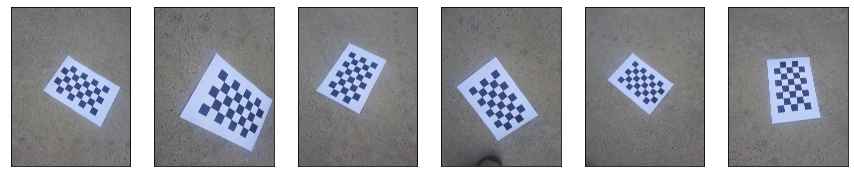

In [8]:
files = glob.glob('./images/chessboard/*.jpg')
images = np.array([cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2RGB) for f in files])

fig, ax = plt.subplots(1, len(images),figsize=(15,15), sharex=True)
for idx in range(len(images)):
    ax[idx].imshow(images[idx])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])

We defined the checkboard parameters

In [3]:
CHECKERBOARD = (4,7)
dx = 30 #mm

The test is best with the checkboard defined static, and the camrea is moving.
It also coorlates to the truth of events </br>
We define the world points for the checkerboard:

In [4]:
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
gridp = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp[0,:,:2] = gridp/dx

Find corners of checkerboards in image:

In [5]:
#sub pixel optimization parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
calibImages = []

for image in images:
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        calibImages.append(image)

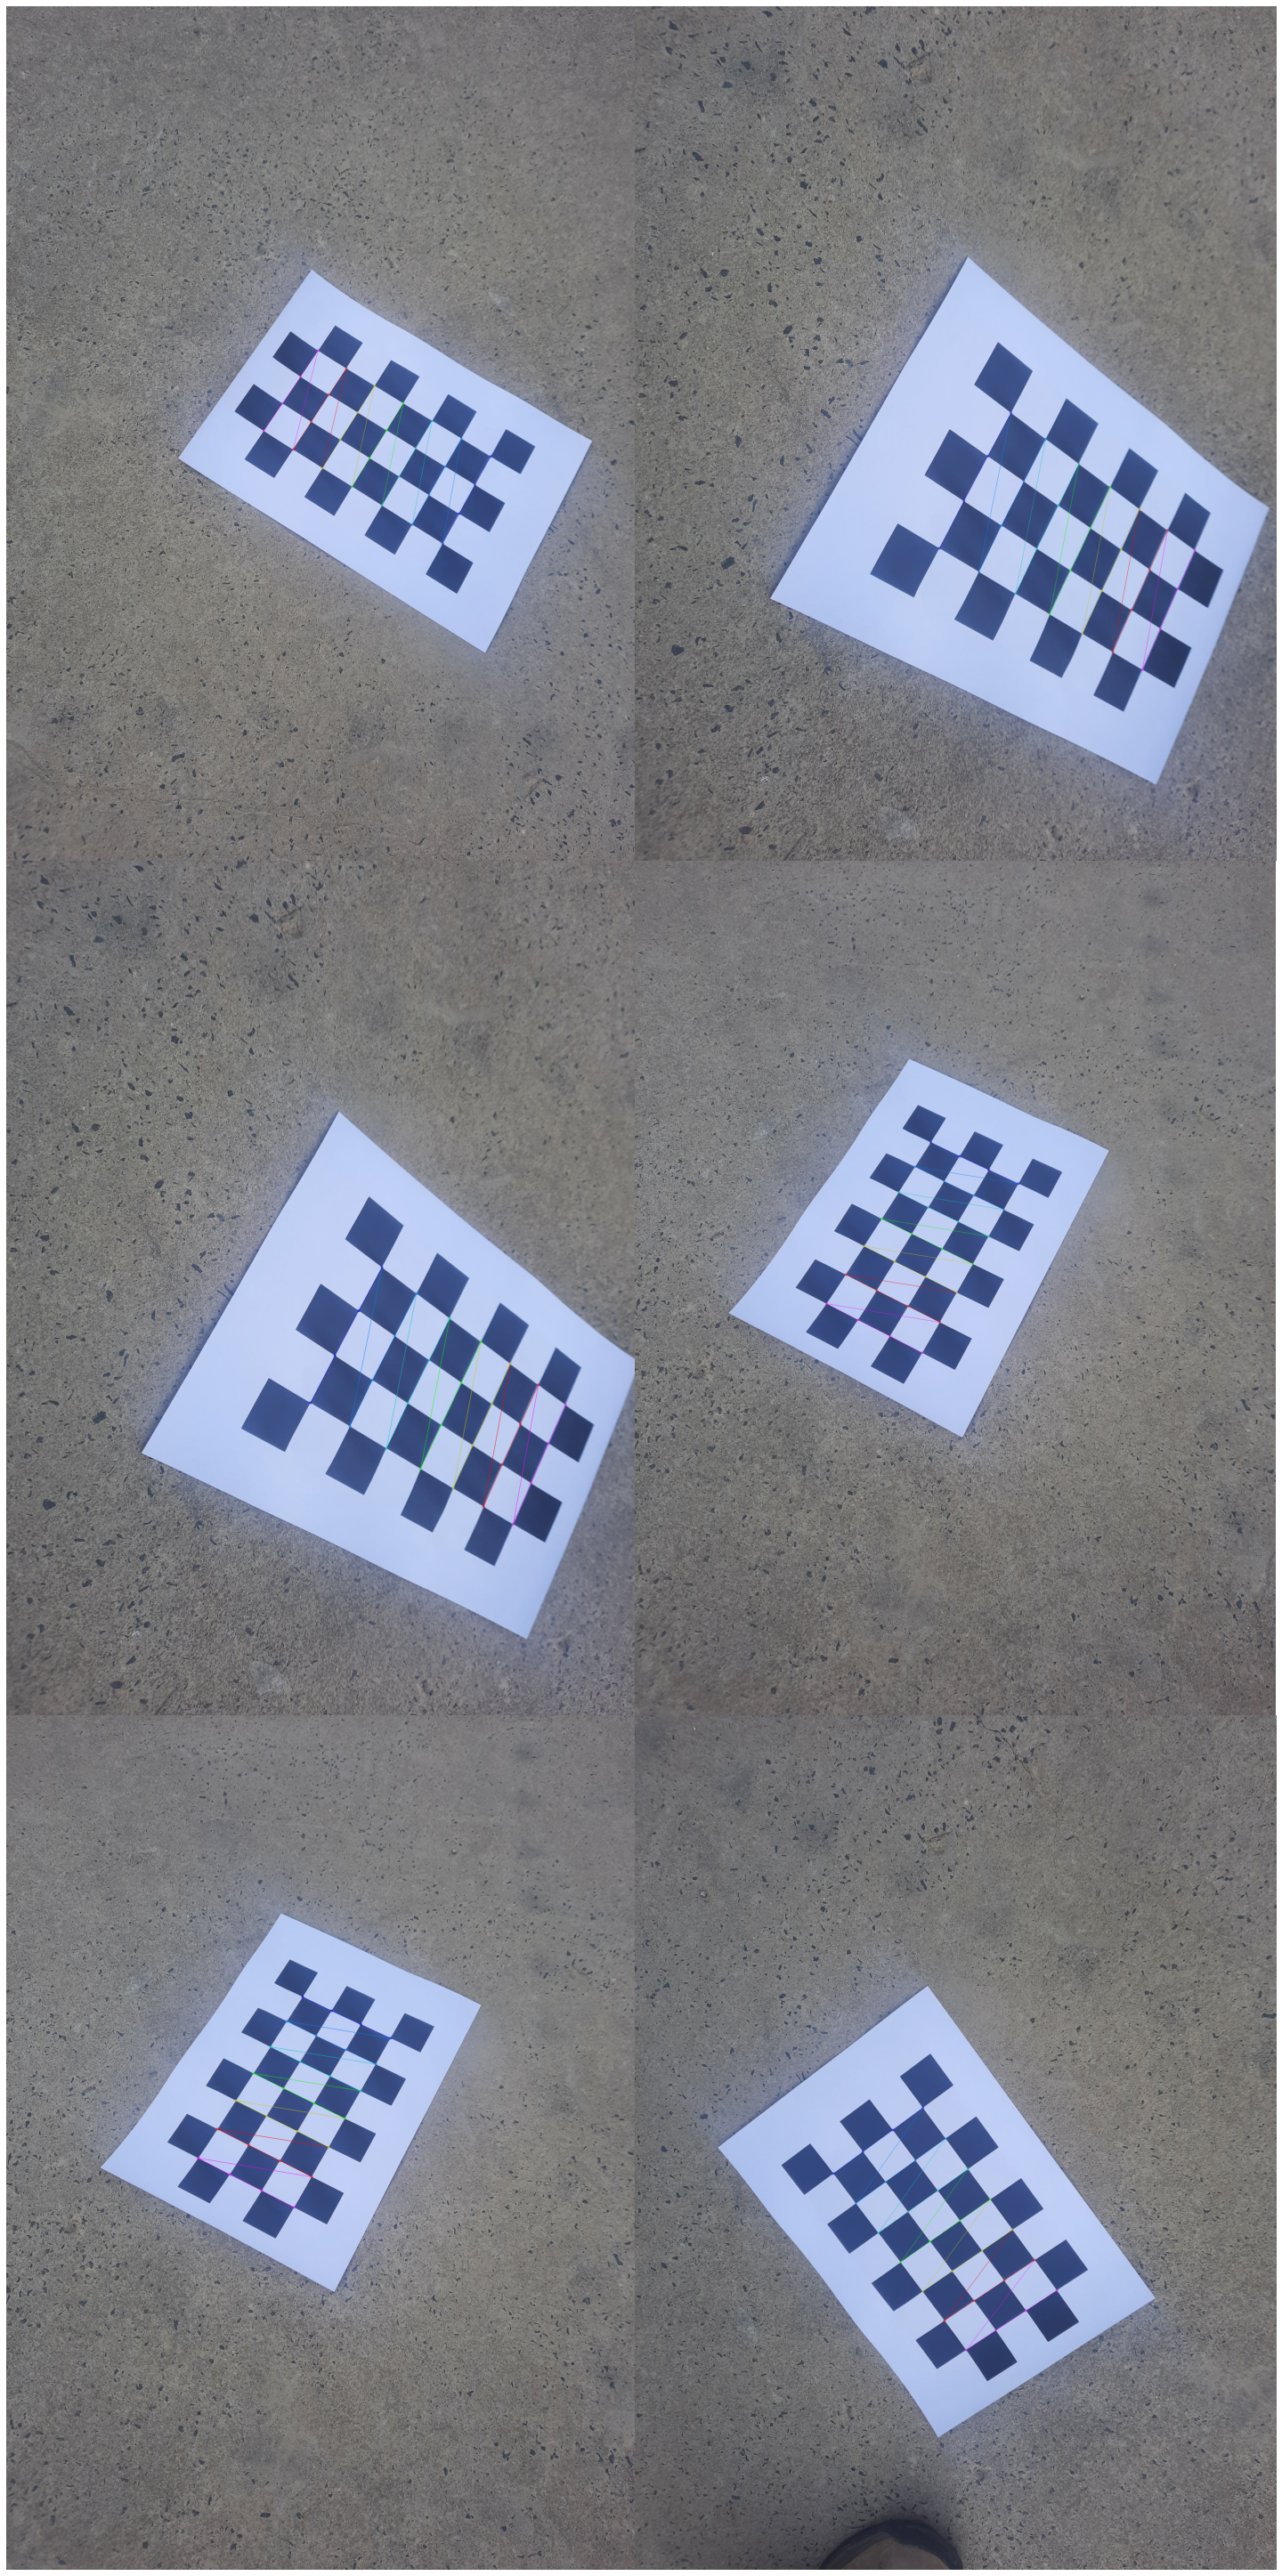

In [40]:
m = len(calibImages)//2
n = 2
fig, ax = plt.subplots(m,n,figsize=(20,40),sharex=True, sharey=True)
for ii in range(m):
    for jj in range(n):
        idx = ii*(n-1)+jj
        img = cv2.drawChessboardCorners(calibImages[idx], CHECKERBOARD, imgpoints[idx],True)
        ax[ii,jj].imshow(img)

for a in ax.ravel():
    a.set_axis_off()
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

Performing camera calibration by 
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the 
detected corners (imgpoints)

In [7]:
imageShape=images[0].shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imageShape[:2][::-1], None, None)


print ("Resolution:")
print(imageShape[:2][::-1])
print("Camera matrix :")
print(mtx)

Resolution:
(3000, 4000)
Camera matrix :
[[3026.994 0.000 1540.323]
 [0.000 3042.652 2028.295]
 [0.000 0.000 1.000]]


That is to say, our $K$:

$K=\begin{bmatrix} f & s & p_x \\ 
                       0 & f & p_y
                        \\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix} 3026.994 & 0 & 1540.323 \\ 
                                                                    0 & 3042.652 & 2028.295
                                                                    \\ 0 & 0 & 1 \end{bmatrix}$

Sanity check: </br>
principle points are approx $1/2$ of the resolution, which makes sense </br>
focal lengths such that an object 1 meter long, standing 1 meter away, will take up most of the picture. sounds right


# Q3

<span style='color:orange'>


In this exercise we will perform basic image feature extraction and matching. You are
free to choose what implementation and programming language to use - one recommended
alternative for the latter is the vlfeat library 3 , which provides also interface to Matlab and
useful tutorials.


(a) Use a camera to capture 2 images of yourself from relatively close viewpoints (not
more than 30 degrees change in yaw angle) </br>
(b) Extract SIFT features in each image.</br>
Please attach the two images with the extracted features. Indicate feature scale and
orientation for a representative feature.</br>
(c) Calculate putative matches by matching SIFT descriptors as explained in class.
Please show, on a separate figure, the calculated matches between the two images.
Among these matches, indicate representative inlier and outlier matches.

</span>

We used https://github.com/rmislam/PythonSIFT

In [1]:
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import PythonSIFT.pysift as pysift

import numpy as np
#formating printing with numpy arrays
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

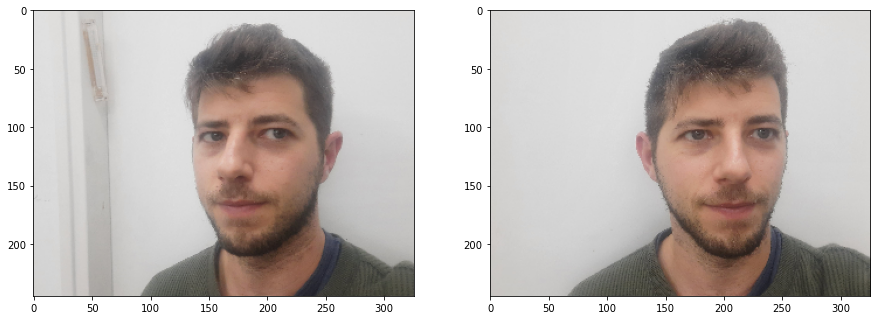

In [8]:
files = glob.glob('./images/sift/*.jpg')
images = np.array([cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2RGB) for f in files])

szimages = [cv2.resize(image,None,fx = 0.1, fy = 0.1) for image in images]

fig, ax = plt.subplots(1, len(szimages),figsize=(15,15))
for idx in range(len(szimages)):
    ax[idx].imshow(szimages[idx])

In [9]:
def plotMatches(im1, im2, p1, p2, N):
    """
    input:
    im1 and im2 are gray images used for calculating p1,p2 in fcn 'getPoints_SIFT'
    
    p1 - features in im1
    p2 - features in im2
    p1[j] matches p2[j]
    p1[j]=[[x[j],y[j]]. to extract x[j] out of p1 do p1[j][0][0]
    industry standard to represent the points as it can be an input to cv2.findhomography
    
    N - amount of matches to show. bounded by p1.shape[0]
    """
    fig = plt.figure(figsize=(20,8))
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    im[0:im1.shape[0], 0:im1.shape[1]] = im1
    im[0:im2.shape[0], im1.shape[1]:] = im2
    plt.imshow(im, cmap='gray')
    
    if N=='max':
        m=range(p1.shape[0])
    else:
        m=range(N[0],N[1]) #amount of matches to show
        
    colors = matplotlib.cm.prism(np.linspace(0, 1, len(m)))
    for i, c in enumerate(colors):
        pt1 = p1[m[i]][0].copy() #.copy() is here because the variable name is a pointer to the array!
        pt2 = p2[m[i]][0].copy()
        pt2[0] += im1.shape[1] #if we dont add .copy() changing pt2[0] will change the input!!
        x = np.asarray([pt1[0], pt2[0]])
        y = np.asarray([pt1[1], pt2[1]])
        plt.plot(x,y,color=c,linewidth=0.4)
        plt.scatter(x,y,color=c,s=3)
    plt.show()
def getPoints_SIFT(im1, im2, method='flann', Nbest=10, plot=0):
    """
    input:
    im1 and im2 are gray images np.arary uint8
    method - siftmethod for feature matching: 'flann','brute_force_crosscheck','brute_force_knn' also options for 'orb'
    Nbest - if method == 'brute_force_crosscheck' take Nbest matches (decided by norm2 distance)
    plot - if plot == 1, plots the matches
    
    output:
    p1 - features in im1
    p2 - features in im2
    p1[j] matches p2[j]
    p1[j]=[[x[j],y[j]]. to extract x[j] out of p1 do p1[j][0][0]
    industry standard to represent the points as it can be an input to cv2.findhomography
    
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
    https://www.uio.no/studier/emner/matnat/its/TEK5030/v19/lect/lecture_4_2_feature_matching.pdf
    https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    """
    
    # Compute SIFT keypoints and descriptors
    kp1, des1 = pysift.computeKeypointsAndDescriptors(im1)
    kp2, des2 = pysift.computeKeypointsAndDescriptors(im2)

    if method.lower() == 'brute_force_crosscheck':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(des1,des2)
        matches = sorted(matches, key = lambda x:x.distance)
        N=min(Nbest,len(matches))
        good = matches[:N]

    if method.lower() == 'brute_force_knn':
        bf = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf.knnMatch(des1,des2, k=2)

        # Lowe's ratio test
        good = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

    elif method.lower() == 'flann':
        # Initialize and use FLANN
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Lowe's ratio test
        good = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
    
    p1 = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2) #src points
    p2 = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2) #dest points
    #p1[j]=[[x[j],y[j]]. to extract x[j] out of p1 do p1[j][0][0]

    if plot:
        plotMatches(im1, im2, p1, p2, 'max')
    
    return p1,p2

/home/alon/OneDrive/Technion/SecondDegree/Technion Courses/086761 - Vision Aided Navigation/git-VANcourse/HW/HW2/PythonSIFT/pysift.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(gaussian_images)
/home/alon/OneDrive/Technion/SecondDegree/Technion Courses/086761 - Vision Aided Navigation/git-VANcourse/HW/HW2/PythonSIFT/pysift.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(dog_images)


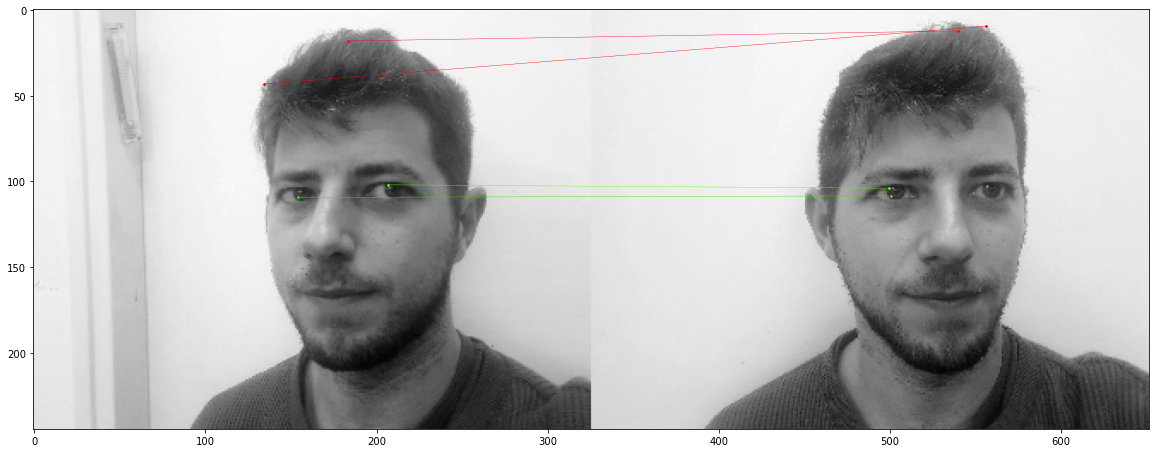

(array([[[134.395, 43.066]],
 
        [[154.067, 109.304]],
 
        [[183.206, 17.936]],
 
        [[206.555, 101.951]]], dtype=float32),
 array([[[230.353, 9.337]],
 
        [[174.666, 108.412]],
 
        [[213.656, 12.054]],
 
        [[173.383, 103.931]]], dtype=float32))

In [10]:
grayImages = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in szimages]
getPoints_SIFT(grayImages[0], grayImages[1],plot=True)